# Day 2: Risk Measures & VaR
## Week 5: Portfolio Optimization

---

### 🎯 Learning Objectives
- Understand Value at Risk (VaR) and Expected Shortfall (ES)
- Implement parametric, historical, and Monte Carlo VaR
- Learn risk budgeting and contribution
- Compare risk measures

| **Monte Carlo** | Flexible | Can model anything | Computationally expensive |

---| **Historical** | Past repeats | Captures fat tails | Limited by history |

| **Parametric** | Normal distribution | Fast, simple | Underestimates tail risk |

### 📈 Why Risk Measures Matter in Trading|--------|------------|------|------|

| Method | Assumption | Pros | Cons |

**VaR is required by regulators and used daily by every bank and hedge fund.**

### The Three VaR Methods

### What Risk Measures Answer

| Solvency II | Insurance companies use VaR for capital |

| Measure | Question Answered || UCITS | Funds limited to 20% 1-month VaR |

|---------|------------------|| Basel III | Banks must hold capital based on VaR |

| **VaR** | "What's the maximum I could lose on a bad day?" ||------------|----------------|

| **ES/CVaR** | "If I do have a bad day, how bad on average?" || Regulation | VaR Requirement |

| **Volatility** | "How much do returns bounce around?" |

### Regulatory Requirements

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from scipy.optimize import minimize
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Constants
TRADING_DAYS = 252  # Trading days per year
RF_RATE = 0.05  # Risk-free rate (5%)

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1254 days


## 1. Value at Risk (VaR)

### 🎯 What is VaR?

**VaR** answers: "What is the maximum loss over a given time period at a given confidence level?"

**Solution:** Use Expected Shortfall (ES) alongside VaR

- 95% VaR: We expect losses to exceed this only 5% of the time

- 99% VaR: We expect losses to exceed this only 1% of the time| **Procyclical** | Rises after losses (when you can't afford it) |

| **No tail info** | Doesn't say HOW BAD the 5% can be |

### How to Read VaR| **Not coherent** | VaR of combined portfolios can exceed sum |

|------------|--------|

| Statement | Meaning || Limitation | Problem |

|-----------|--------|

| "95% 1-day VaR is $10,000" | 5% chance of losing more than $10K tomorrow |### VaR Limitations

| "99% 1-day VaR is $25,000" | 1% chance of losing more than $25K tomorrow |

In [ ]:
# Create portfolio
print("=" * 60)
print("PORTFOLIO SETUP")
print("=" * 60)

# Equal weight portfolio
weights = np.array([1/len(tickers)] * len(tickers))
portfolio_value = 1_000_000  # $1M portfolio

# Portfolio returns
port_returns = returns.dot(weights)

print(f"\nPortfolio Statistics:")
print(f"  Mean Daily Return: {port_returns.mean():.4%}")
print(f"  Daily Volatility: {port_returns.std():.4%}")
print(f"  Annualized Return: {port_returns.mean() * TRADING_DAYS:.2%}")
print(f"  Annualized Volatility: {port_returns.std() * np.sqrt(TRADING_DAYS):.2%}")

PORTFOLIO SETUP

Portfolio Statistics:
  Mean Daily Return: 0.0916%
  Daily Volatility: 1.3097%
  Annualized Return: 23.09%
  Annualized Volatility: 20.79%


In [ ]:
# Three methods to calculate VaR
print("=" * 60)
print("VALUE AT RISK (VaR) METHODS")
print("=" * 60)

confidence_level = 0.95
alpha = 1 - confidence_level

# Method 1: Parametric (Normal) VaR
mu = port_returns.mean()
sigma = port_returns.std()
z_score = stats.norm.ppf(alpha)
parametric_var = -(mu + z_score * sigma)

print(f"\n📊 Method 1: Parametric (Normal) VaR")
print(f"  Assumption: Returns ~ N({mu:.6f}, {sigma:.6f})")
print(f"  Z-score at {alpha:.0%}: {z_score:.4f}")
print(f"  1-Day {confidence_level:.0%} VaR: {parametric_var:.4%}")
print(f"  Dollar VaR: ${portfolio_value * parametric_var:,.0f}")

# Method 2: Historical VaR
historical_var = -port_returns.quantile(alpha)

print(f"\n📊 Method 2: Historical VaR")
print(f"  No distributional assumption")
print(f"  1-Day {confidence_level:.0%} VaR: {historical_var:.4%}")
print(f"  Dollar VaR: ${portfolio_value * historical_var:,.0f}")

# Method 3: Monte Carlo VaR
n_simulations = 10000
simulated_returns = np.random.normal(mu, sigma, n_simulations)
mc_var = -np.percentile(simulated_returns, alpha * 100)

print(f"\n📊 Method 3: Monte Carlo VaR")
print(f"  Simulations: {n_simulations:,}")
print(f"  1-Day {confidence_level:.0%} VaR: {mc_var:.4%}")
print(f"  Dollar VaR: ${portfolio_value * mc_var:,.0f}")

VALUE AT RISK (VaR) METHODS

📊 Method 1: Parametric (Normal) VaR
  Assumption: Returns ~ N(0.000916, 0.013097)
  Z-score at 5%: -1.6449
  1-Day 95% VaR: 2.0626%
  Dollar VaR: $20,626

📊 Method 2: Historical VaR
  No distributional assumption
  1-Day 95% VaR: 2.0026%
  Dollar VaR: $20,026

📊 Method 3: Monte Carlo VaR
  Simulations: 10,000
  1-Day 95% VaR: 2.0309%
  Dollar VaR: $20,309


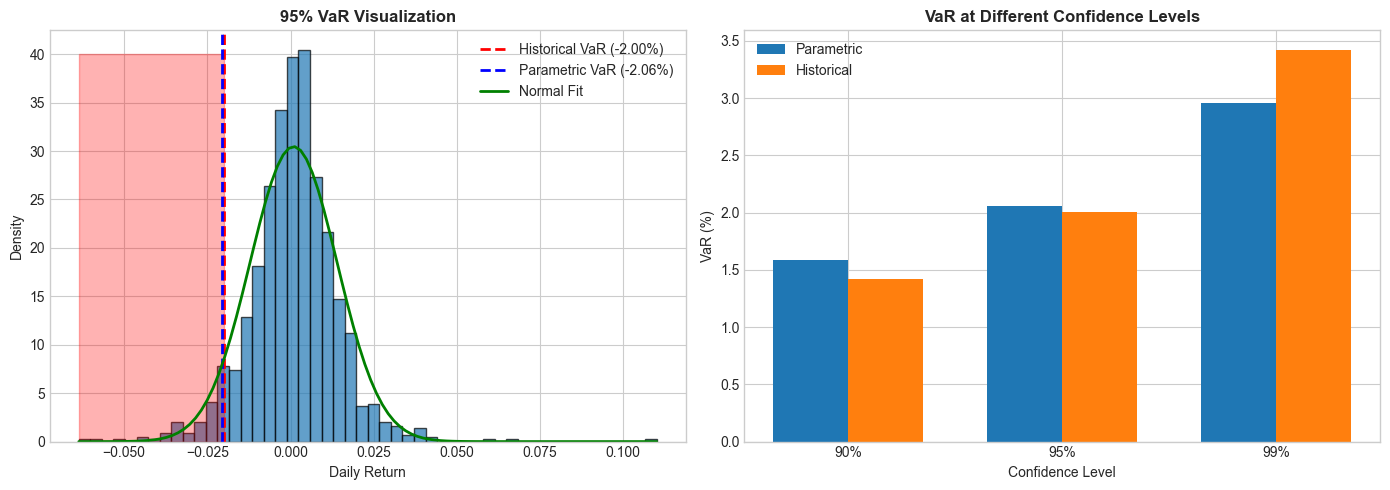


VaR Comparison:
Confidence  Parametric  Historical
       90%    0.015868    0.014189
       95%    0.020626    0.020026
       99%    0.029551    0.034219


In [ ]:
# Visualize VaR
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Historical distribution
axes[0].hist(port_returns, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[0].axvline(-historical_var, color='red', linestyle='--', linewidth=2, 
                label=f'Historical VaR ({-historical_var:.2%})')
axes[0].axvline(-parametric_var, color='blue', linestyle='--', linewidth=2,
                label=f'Parametric VaR ({-parametric_var:.2%})')

# Overlay normal distribution
x = np.linspace(port_returns.min(), port_returns.max(), 100)
axes[0].plot(x, stats.norm.pdf(x, mu, sigma), 'g-', linewidth=2, label='Normal Fit')

axes[0].fill_betweenx([0, 40], port_returns.min(), -historical_var, alpha=0.3, color='red')
axes[0].set_xlabel('Daily Return')
axes[0].set_ylabel('Density')
axes[0].set_title(f'{confidence_level:.0%} VaR Visualization', fontweight='bold')
axes[0].legend()

# VaR at different confidence levels
confidence_levels = [0.90, 0.95, 0.99]
var_comparison = []

for cl in confidence_levels:
    a = 1 - cl
    var_comparison.append({
        'Confidence': f'{cl:.0%}',
        'Parametric': -(mu + stats.norm.ppf(a) * sigma),
        'Historical': -port_returns.quantile(a)
    })

var_df = pd.DataFrame(var_comparison)
x_pos = np.arange(len(confidence_levels))
width = 0.35

axes[1].bar(x_pos - width/2, var_df['Parametric'] * 100, width, label='Parametric')
axes[1].bar(x_pos + width/2, var_df['Historical'] * 100, width, label='Historical')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(var_df['Confidence'])
axes[1].set_xlabel('Confidence Level')
axes[1].set_ylabel('VaR (%)')
axes[1].set_title('VaR at Different Confidence Levels', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nVaR Comparison:")
print(var_df.to_string(index=False))

## 2. Expected Shortfall (CVaR)

**Expected Shortfall** (Conditional VaR): Average loss given that loss exceeds VaR

In [ ]:
# Expected Shortfall
print("=" * 60)
print("EXPECTED SHORTFALL (CVaR)")
print("=" * 60)

def calculate_es(returns, confidence_level=0.95):
    """Calculate Expected Shortfall (CVaR)."""
    alpha = 1 - confidence_level
    var = -returns.quantile(alpha)
    es = -returns[returns <= -var].mean()
    return var, es

# Historical ES
var_95, es_95 = calculate_es(port_returns, 0.95)
var_99, es_99 = calculate_es(port_returns, 0.99)

print(f"\n📊 95% Confidence:")
print(f"  VaR: {var_95:.4%} (${portfolio_value * var_95:,.0f})")
print(f"  ES:  {es_95:.4%} (${portfolio_value * es_95:,.0f})")

print(f"\n📊 99% Confidence:")
print(f"  VaR: {var_99:.4%} (${portfolio_value * var_99:,.0f})")
print(f"  ES:  {es_99:.4%} (${portfolio_value * es_99:,.0f})")

# Parametric ES (for normal distribution)
def parametric_es(mu, sigma, confidence_level=0.95):
    alpha = 1 - confidence_level
    var = -(mu + stats.norm.ppf(alpha) * sigma)
    es = -mu + sigma * stats.norm.pdf(stats.norm.ppf(alpha)) / alpha
    return var, es

p_var, p_es = parametric_es(mu, sigma, 0.95)
print(f"\n📊 Parametric ES (95%):")
print(f"  VaR: {p_var:.4%}")
print(f"  ES:  {p_es:.4%}")

EXPECTED SHORTFALL (CVaR)

📊 95% Confidence:
  VaR: 2.0026% ($20,026)
  ES:  2.8747% ($28,747)

📊 99% Confidence:
  VaR: 3.4219% ($34,219)
  ES:  4.2739% ($42,739)

📊 Parametric ES (95%):
  VaR: 2.0626%
  ES:  2.6098%


## 3. Risk Contribution

RISK CONTRIBUTION

Portfolio Volatility: 20.79%

📊 Risk Contribution Analysis:
Asset  Weight  Marginal RC  Risk Contribution     RC %
 AAPL     0.2     0.217097           0.043419 0.208845
 MSFT     0.2     0.243816           0.048763 0.234549
GOOGL     0.2     0.207096           0.041419 0.199224
  JPM     0.2     0.171653           0.034331 0.165129
   GS     0.2     0.199849           0.039970 0.192253


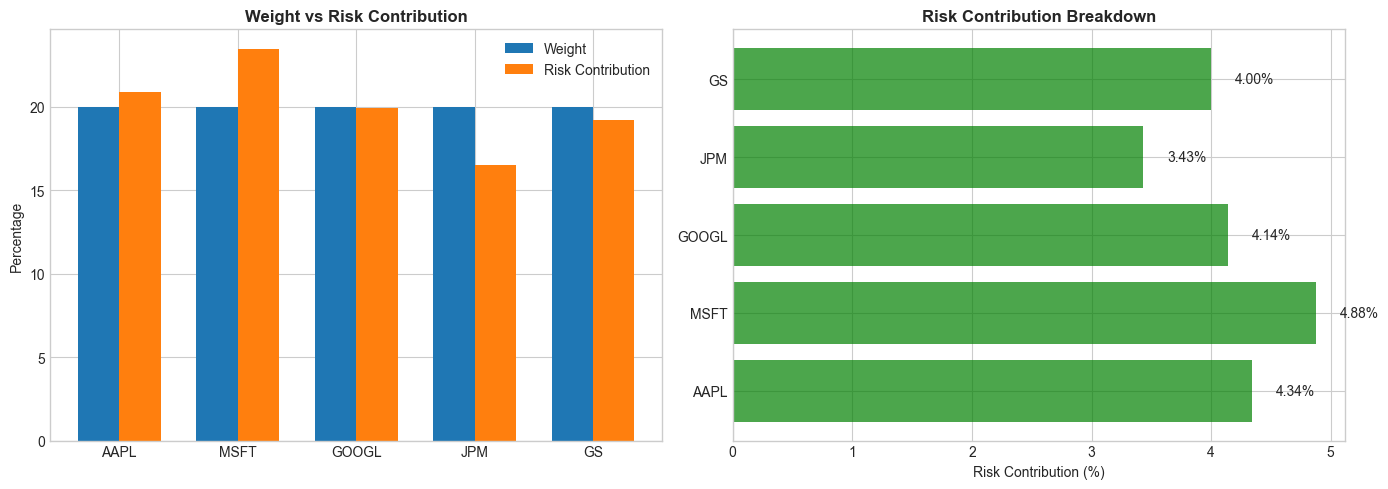

In [ ]:
# Risk contribution analysis
print("=" * 60)
print("RISK CONTRIBUTION")
print("=" * 60)

cov_matrix = returns.cov() * TRADING_DAYS

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def marginal_risk_contribution(weights, cov_matrix):
    """Calculate marginal risk contribution of each asset."""
    port_vol = portfolio_volatility(weights, cov_matrix)
    return np.dot(cov_matrix, weights) / port_vol

def risk_contribution(weights, cov_matrix):
    """Calculate risk contribution of each asset."""
    mrc = marginal_risk_contribution(weights, cov_matrix)
    return weights * mrc

# Calculate for equal weight portfolio
port_vol = portfolio_volatility(weights, cov_matrix)
mrc = marginal_risk_contribution(weights, cov_matrix)
rc = risk_contribution(weights, cov_matrix)

print(f"\nPortfolio Volatility: {port_vol:.2%}")
print(f"\n📊 Risk Contribution Analysis:")

rc_df = pd.DataFrame({
    'Asset': tickers,
    'Weight': weights,
    'Marginal RC': mrc,
    'Risk Contribution': rc,
    'RC %': rc / rc.sum()
})
print(rc_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Weight vs Risk Contribution
x = np.arange(len(tickers))
width = 0.35

axes[0].bar(x - width/2, weights * 100, width, label='Weight')
axes[0].bar(x + width/2, (rc / rc.sum()) * 100, width, label='Risk Contribution')
axes[0].set_xticks(x)
axes[0].set_xticklabels(tickers)
axes[0].set_ylabel('Percentage')
axes[0].set_title('Weight vs Risk Contribution', fontweight='bold')
axes[0].legend()

# Bar chart of risk contribution (handles negative values better than pie)
colors = ['green' if v >= 0 else 'red' for v in rc]
axes[1].barh(tickers, rc * 100, color=colors, alpha=0.7)
axes[1].axvline(0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Risk Contribution (%)')
axes[1].set_title('Risk Contribution Breakdown', fontweight='bold')
for i, (asset, val) in enumerate(zip(tickers, rc)):
    axes[1].text(val * 100 + 0.2, i, f'{val:.2%}', va='center')

plt.tight_layout()
plt.show()

## 4. Risk Parity Portfolio

In [ ]:
# Risk parity optimization
print("=" * 60)
print("RISK PARITY PORTFOLIO")
print("=" * 60)

def risk_parity_objective(weights, cov_matrix):
    """Objective: minimize deviation from equal risk contribution."""
    n = len(weights)
    rc = risk_contribution(weights, cov_matrix)
    target_rc = portfolio_volatility(weights, cov_matrix) / n
    
    # Sum of squared deviations from target
    return np.sum((rc - target_rc) ** 2)

# Optimize
n_assets = len(tickers)
initial_weights = np.array([1/n_assets] * n_assets)

constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = tuple((0.01, 1) for _ in range(n_assets))

result = minimize(
    risk_parity_objective,
    initial_weights,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

rp_weights = result.x
rp_rc = risk_contribution(rp_weights, cov_matrix)

print(f"\n📊 Risk Parity Portfolio:")
rp_df = pd.DataFrame({
    'Asset': tickers,
    'Weight': rp_weights,
    'Risk Contribution': rp_rc,
    'RC %': rp_rc / rp_rc.sum()
})
print(rp_df.to_string(index=False))

print(f"\nPortfolio Volatility: {portfolio_volatility(rp_weights, cov_matrix):.2%}")

# Compare to equal weight
print(f"\n📊 Comparison:")
print(f"  Equal Weight Vol: {portfolio_volatility(weights, cov_matrix):.2%}")
print(f"  Risk Parity Vol: {portfolio_volatility(rp_weights, cov_matrix):.2%}")

RISK PARITY PORTFOLIO

📊 Risk Parity Portfolio:
Asset   Weight  Risk Contribution     RC %
 AAPL 0.191953           0.041157 0.199959
 MSFT 0.171746           0.040591 0.197209
GOOGL 0.197107           0.041642 0.202318
  JPM 0.231146           0.041163 0.199989
   GS 0.208048           0.041273 0.200525

Portfolio Volatility: 20.58%

📊 Comparison:
  Equal Weight Vol: 20.79%
  Risk Parity Vol: 20.58%


## 📝 Key Takeaways - Day 2

### VaR Methods:
| Method | Pros | Cons |
|--------|------|------|
| Parametric | Fast, simple | Assumes normality |
| Historical | No assumptions | Limited by history |
| Monte Carlo | Flexible | Computationally intensive |

### VaR vs ES:
- **VaR**: "What's the worst that can happen (at confidence level)?" 
- **ES**: "If things go bad, how bad?" (more conservative)

### Risk Parity:
- Each asset contributes equally to portfolio risk
- Typically leads to higher bond allocation
- More diversified risk exposure

### Interview Questions:
- "Explain the difference between VaR and Expected Shortfall"
- "What are the limitations of VaR?"
- "What is a risk parity portfolio?"

## 🔴 PROS & CONS: Risk Measures VaR

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [ ]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - Risk Measures VaR Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-22 15:00

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $247.65
   GOOGL: $328.38
   GS: $953.01
   JPM: $302.04
   MSFT: $444.11

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -8.61%
   🟢 GOOGL: +6.00%
   🟢 GS: +6.01%
   🔴 JPM: -6.09%
   🔴 MSFT: -8.42%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟢 BULLISH - Consider long positions
   GS: 🟢 BULLISH - Consider long positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🔴 BEARISH - Consider reducing exposure

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
